In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import datetime as dt
import mplfinance 
import fx

from collections import deque
from renkodf import Renko
from scipy.signal import lfilter
from deap import base, creator, tools
from scipy.stats import zscore
from tqdm.notebook import tqdm

In [6]:
# bring in the spread data
spread = pd.read_csv('spread_results_03_11_24_03_12_24.csv', index_col=0)

In [7]:
# convert date to datetime
# df_full['datetime'] = pd.to_datetime(df_full['date'] + ' ' + df_full['time'], format='%Y.%m.%d %H:%M')
# filter the data to just 2023

# df_2022 = fx.prep_data(df_full, 2022)
# df_2023 = fx.prep_data(df_full, 2023)
# df_2024 = fx.prep_data(df_full, 2024)

# Parameters

In [8]:
# Renko variable
initial_brick_size = 0.0003
# create a list of possible brick sizes a max at 0.001 and min at 0.00001 and each step is 0.00001
brick_size_list = np.arange(0.0005, 0.00101, 0.00001)
brick_size_str = str(int(initial_brick_size*10000))

# sma variables
initial_sma_length = 3
sma_length_list = np.arange(3, 20, 1)
initial_smoothing_sma = 3
smoothing_sma_list = np.arange(3, 20, 1)


In [9]:
# Lot Size
initial_lot_size = 3
lot_sizes_list = np.arange(1, 5, 1)
per_lot = 100000

# Commissions
nova_commission = -3
msolutions_commission = -5

# starting balance
balance = 200000

# base currency rate
base_currency_rate = 0.045 # EUR
quote_currency_rate = 0.055 # USD

# Optimization

In [10]:
def renko_ready(brick_size):
    brick_size_str_fx = str(int(brick_size*100000))
    # create a renko chart from the df dataframe
    renko_data = pd.read_csv(f'./brick_size_variations/renko_full_data_{brick_size_str_fx}.csv')
    renko_data['datetime'] = pd.to_datetime(renko_data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
    renko_data = renko_data.set_index('datetime')
    return renko_data


In [11]:
def adding_cols(df, sma_length, smoothing_sma, brick_size):
        # stop loss
        stop_loss = brick_size*2
        # take profit
        take_profit_size = brick_size*4
        # calculate the sma of the open high low, close / 4 for sma_length periods
        df['ohlc4'] = (df['close'] + df['open'] + df['high'] + df['low']) / 4
        df['sma'] = df['ohlc4'].rolling(window=sma_length).mean()
        # calculate the smoothing_sma of sma for smoothing_sma periods
        df['smoothing_sma'] = df['sma'].rolling(window=smoothing_sma).mean()
        # find the difference between sma and smoothing_sma
        df['sma_diff'] = df['sma'] - df['smoothing_sma']
        # find the sign of the sma_diff
        df['sma_sign'] = np.sign(df['sma_diff'])
        # find where the sma_sign changes from 1 to -1 or -1 to 1 or from 1
        df['sma_crossover'] = np.where((df['sma_sign'] == 1) & (df['sma_sign'].shift(1) == -1), 1, 
                                        np.where((df['sma_sign'] == -1) & (df['sma_sign'].shift(1) == 1), -1, 
                                        np.where((df['sma_sign'] == -1) & (df['sma_sign'].shift(1) == 0) & (df['sma_sign'].shift(2) == 1), -1,
                                        np.where((df['sma_sign'] == 1) & (df['sma_sign'].shift(1) == 0) & (df['sma_sign'].shift(2) == -1), 1, 0))))
        # when sma_crossover is 1 then buy, when sma_crossover is -1 then sell
        df['sma_signal'] = np.where(df['sma_crossover'] == 1, 'buy',
                                        np.where(df['sma_crossover'] == -1, 'sell', ''))
        # add the day of the week to the dataframe
        df['day_of_week'] = df.index.day_name()
        # place a 1 in day_of_week_transition, if it is the last bar on Friday and the next bar is Sunday
        df['day_of_week_transition'] = np.where((df['day_of_week'] == 'Friday') & 
                                                        ((df['day_of_week'].shift(-1) == 'Sunday') | 
                                                        (df['day_of_week'].shift(-1) == 'Monday') |
                                                        (df['day_of_week'].shift(-1) == 'Tuesday')), 1, 0)
        # if the day_of_week_transition is 1 and the sma_signal is 1 then replace sma_signal with ''
        df['sma_signal'] = np.where((df['day_of_week_transition'] == 1), 'exit', df['sma_signal'])
        # Forward fill 'exit' values up to the next 'buy' or 'sell'
        mask = df['sma_signal'].isin(['buy', 'sell'])
        df['sma_signal'] = df['sma_signal'].where(mask | (df['sma_signal'] == 'exit')).ffill()
        fx.cum_count(df)
        fx.add_tp_sl(df, take_profit_size, stop_loss)
    
        return df



In [12]:
def calc_profit_loss(df, lots):
    profit_df = pd.DataFrame() #columns=['cum_position_count', 'direction', 'entry_price', 'exit_price', 'first_TP_hit', 'profit']
    # calculate the profit for each position by first grouping by each position and finding the entry price
    profit_df['entry_price'] = df.groupby('cum_position_count')['close'].first()
    # separate out the datetime column
    df['datetime'] = df.index
    # get the entry and exit times
    profit_df['entry_time'] = df.groupby('cum_position_count')['datetime'].first()
    profit_df['exit_time'] = df.groupby('cum_position_count')['datetime'].last()
    # # determine the exit price
    profit_df['exit_price'] = df.groupby('cum_position_count')['close'].last()
    # # what was the direction, long or short?
    profit_df['direction'] = df.groupby('cum_position_count')['sma_signal'].first()
    profit_df['Nova_profit_initial'] = np.where((profit_df['direction'].str.strip() == 'buy'),
                                            ((profit_df['exit_price'] + spread.loc['Close Spread Buy', 'Nova']) - (profit_df['entry_price'] + spread.loc['Spread Buy', 'Nova']))
                                            * per_lot * lots, 
                                            np.where((profit_df['direction'].str.strip() == 'sell'),
                                                    ((profit_df['entry_price'] + spread.loc['Spread Sell', 'Nova']) - (profit_df['exit_price'] + spread.loc['Close Spread Sell', 'Nova']))
                                                    * per_lot * lots, np.nan))
    profit_df['MSolutions_profit_initial'] = np.where((profit_df['direction'].str.strip() == 'buy'),
                                                ((profit_df['exit_price'] + spread.loc['Close Spread Buy', 'MSolutions']) - (profit_df['entry_price'] + spread.loc['Spread Buy', 'MSolutions']))
                                                * per_lot * lots, 
                                                np.where((profit_df['direction'].str.strip() == 'sell'),
                                                        ((profit_df['entry_price'] + spread.loc['Spread Sell', 'MSolutions']) - (profit_df['exit_price'] + spread.loc['Close Spread Sell', 'MSolutions']))
                                                        * per_lot * lots, np.nan))
    profit_df = fx.add_swap_rates(profit_df, base_currency_rate, quote_currency_rate, lots=lots)
    profit_df['nova_profit'] = profit_df['Nova_profit_initial'] + (nova_commission*lots) + profit_df['swap_rate']
    profit_df['msolutions_profit'] = profit_df['MSolutions_profit_initial'] + (msolutions_commission*lots) + profit_df['swap_rate']
    # use the entry time and resample to each day and find the sum of the profit
    profit_df['entry_time'] = pd.to_datetime(profit_df['entry_time'])
    profit_df_new_index = profit_df.set_index('entry_time')
    # find the sum of the nova and msolutions profit for each day
    profit_df_daily = profit_df_new_index.resample('D').agg({'nova_profit': 'sum', 'msolutions_profit': 'sum'})
    # drop the weekends by first adding in a new day of the week column
    profit_df_daily['day_of_week'] = profit_df_daily.index.day_name()
    # drop any day that is Saturday or Sunday
    profit_df_daily = profit_df_daily.loc[(profit_df_daily['day_of_week'] != 'Saturday') & (profit_df_daily['day_of_week'] != 'Sunday')]
    # find the number of times that profit_df_daily is below zero
    profit_df_daily['nova_negative'] = np.where(profit_df_daily['nova_profit'] < 0, 1, 0)
    profit_df_daily['msolutions_negative'] = np.where(profit_df_daily['msolutions_profit'] < 0, 1, 0)
    # find the sum of nova_negative and msolutions_negative
    nova_negative_sum = profit_df_daily['nova_negative'].sum()
    msolutions_negative_sum = profit_df_daily['msolutions_negative'].sum()
    # find the sum of nova_profit
    nova_profit_sum = profit_df['nova_profit'].sum()
    msolutions_profit_sum = profit_df['msolutions_profit'].sum()
    # calculate the profit factor by first finding the sum of the losses
    msolutions_losses = profit_df.loc[profit_df['msolutions_profit'] < 0, 'msolutions_profit'].sum()
    nova_losses = profit_df.loc[profit_df['nova_profit'] < 0, 'nova_profit'].sum()
    # now find the profit factor
    if msolutions_losses == 0:
        msolutions_profit_factor = float('inf')
        nova_profit_factor = float('inf')
    else:
        msolutions_profit_factor = msolutions_profit_sum / abs(msolutions_losses)
        nova_profit_factor = nova_profit_sum / abs(nova_losses)       

    return msolutions_profit_sum, msolutions_negative_sum, msolutions_profit_factor # nova_profit_sum, nova_negative_sum

In [13]:
def making_calculations(brick_size, sma_length, smoothing_sma, lot_size):
    renko_data = renko_ready(brick_size)
    # add the columns necessary for the strategy
    renko_data_cols_added = adding_cols(renko_data, sma_length, smoothing_sma, brick_size)
    # determine the profit/loss for the strategy
    total_profit, days_in_drawdown, profit_factor = calc_profit_loss(renko_data_cols_added, lot_size)

    return total_profit, days_in_drawdown, profit_factor

# Basic Parameters 
Just looking if there is an a brick_size that is profitable

In [14]:
# # initize a dataframe to store the results
# basic_parameters = pd.DataFrame(columns=['run', 'brick_size', 'total_profit', 'days_in_drawdown', 'profit_factor'])
# for idx, brick_size in enumerate(brick_size_list):
#     print(brick_size)
#     total_profit, days_in_drawdown, profit_factor = making_calculations(brick_size, initial_sma_length, initial_smoothing_sma, 2)
#     # print(f'run: {idx}, brick_size: {brick_size}, profit: {total_profit}, days_in_drawdown: {days_in_drawdown}, profit_factor: {profit_factor}')
#     # save it to a dataframe
#     basic_parameters = pd.concat([basic_parameters, pd.DataFrame({'run': idx, 'brick_size': brick_size, 
#         'total_profit': total_profit, 'days_in_drawdown': days_in_drawdown, 'profit_factor': profit_factor}, index=[0])])

In [15]:
basic_parameters = pd.read_csv('basic_parameters.csv', index_col=0)

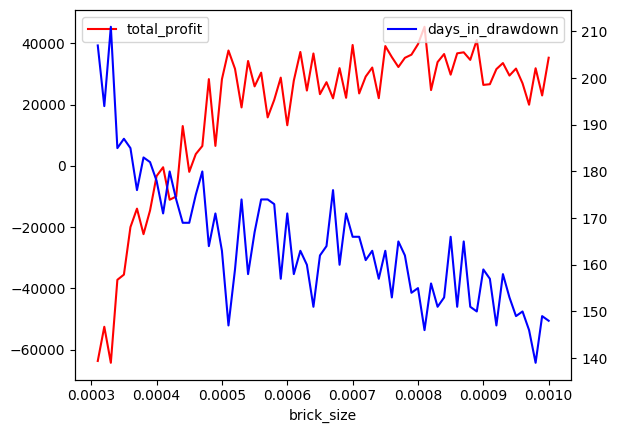

In [16]:
# create a graph with brick_size as the x-axis, total_profit, and days in drawdown on 2 separate y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
basic_parameters.plot(x='brick_size', y='total_profit', ax=ax1, color='r')
basic_parameters.plot(x='brick_size', y='days_in_drawdown', ax=ax2, color='b')
plt.show()


In [17]:
# save basic_parameters to a csv file
# basic_parameters.to_csv('basic_parameters.csv')

In [19]:
# find the max date of df_2024 
# df_2024.index.max()

In [20]:
# results for standard values
# print('2022 data: ', making_calculations(df_2022, initial_brick_size, start, maximum, lengthMA, lengthSignal, initial_brick_size*2, initial_lot_size))
# print('2023 data: ', making_calculations(df_2023, initial_brick_size, start, maximum, lengthMA, lengthSignal, initial_brick_size*2, initial_lot_size))
# print('2024 data: ', making_calculations(df_2024, initial_brick_size, start, maximum, lengthMA, lengthSignal, initial_brick_size*2, initial_lot_size))
# print('last 3 months data: ', making_calculations(df_tick_ready, initial_brick_size, start, maximum, lengthMA, lengthSignal, initial_brick_size*2, initial_lot_size))
# 2022 data:  ($1,136,669.99, 53)
# 2023 data:  ($447,824.99, 82)
# 2024 data:  ($20,509.99, 15)
# last 3 months data:  (23,329.99, 33)

In [21]:
lol = [brick_size_list, sma_length_list, smoothing_sma_list] # , lot_sizes_list,  
def constraint_handler(individual):
    counter = 0
    for i, lst in zip(individual, lol):
        # Ensure parameter is greater than   0
        if (i <= 0) | ((counter == len(individual) - 1) & (i < 2)):
            individual[counter] = np.random.choice(lst)  # Reset to a valid value
        counter += 1
    return individual

In [33]:
# Define the fitness function
import sys
# Check if FitnessMax already exists in the __main__ namespace
if 'FitnessMax' not in sys.modules['__main__'].__dict__:
    # If not, create it
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

if 'Individual' not in sys.modules['__main__'].__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMax)

population_size = 100
global_total_profits = []  # A list to collect total profits from all individuals
global_days_in_drawdowns = []  # A list to collect days in drawdown from all individuals
# Global variables to keep track of the number of evaluations
num_evaluations = 0
discard_threshold = 20  # Discard the first 20 evaluations

toolbox = base.Toolbox()

# Register an attribute generator for each parameter with its own range
toolbox.register("brick_size", np.random.choice, brick_size_list)
toolbox.register("sma_length", np.random.choice, sma_length_list)
toolbox.register("smoothing_sma", np.random.choice, smoothing_sma_list)
# toolbox.register("lot_size", np.random.choice, lot_sizes_list)

# Combine the attribute generators to create an individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                  (toolbox.brick_size, toolbox.sma_length, toolbox.smoothing_sma))# , toolbox.lot_size, 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# initialize a dataframe for the each evaluation
eval_df = pd.DataFrame(columns=['brick_size', 'sma_length', 'smoothing_sma', 'total_profit', 'days_in_drawdown', 'profit_factor'])


def eval_func(individual):
    # Assuming these are global variables accessible within the scope of eval_func
    global global_total_profits  # A list to collect total profits from all individuals
    global global_days_in_drawdowns  # A list to collect days in drawdown from all individuals
    global num_evaluations  # A global variable to keep track of the number of evaluations
    global eval_df

    # Unpack individual parameters
    brick_size, sma_length, smoothing_sma = individual #, lot_size, brick_size
    print(brick_size, sma_length, smoothing_sma) # , lot_size, brick_size
    for i in individual:
        if i <= 0:
            individual = constraint_handler(individual)
            brick_size, sma_length, smoothing_sma = individual #, lot_size,
            print(brick_size, sma_length, smoothing_sma) #, lot_size, 

    # Perform calculations using these parameters
    total_profit, days_in_drawdown, profit_factor = making_calculations(brick_size, int(sma_length), int(smoothing_sma), initial_lot_size)
    print(total_profit, days_in_drawdown, profit_factor)

    # Update the global lists with the new values
    global_total_profits.append(total_profit)
    # print(global_total_profits)
    global_days_in_drawdowns.append(days_in_drawdown)
    
    num_evaluations +=  1
    # save the results to a dataframe
    eval_df = pd.concat([eval_df, pd.DataFrame({'brick_size': brick_size, 'sma_length': sma_length, 'smoothing_sma': smoothing_sma,
                                                'total_profit': total_profit, 'days_in_drawdown': days_in_drawdown, 'profit_factor': profit_factor}, 
                                                index=[num_evaluations])])


    if len(global_total_profits) > discard_threshold:
        # Normalize total_profit and days_in_drawdown independently
        norm_total_profit = zscore(global_total_profits)[-1]
        norm_days_in_drawdown = zscore(global_days_in_drawdowns)[-1]
        # Combine the scores
        score = norm_total_profit - norm_days_in_drawdown
        if norm_total_profit == 0:
            score = 0
        print(score)
        return (score,)
    else:
        print(num_evaluations)
        return (0,)

toolbox.register("evaluate", eval_func)

# Define the feasibility function
def feasible(individual):
    for i, lst in zip(individual, lol):
        # find the min of the list
        min = lst.min()
        # find the max of the list
        max = lst.max()
        if i < min or i > max:
            return False
    return True

# Define a distance function to the feasibility region
def distance(individual):
    distances = 0
    for i, lst in zip(individual, lol):
        # find the min of the list
        min = lst.min()
        # find the max of the list
        max = lst.max()
        if i < min:
            # find out how far away from the min the parameter is and then normalize it
            dist = abs(i - min) / (max - min)
        elif i > max:
            # find out how far away from the max the parameter is and then normalize it
            dist = abs(i - max) / (max - min)
        else:
            dist = 0
        distances += dist
    return distances  # Distance from the feasibility region

# Decorate the evaluation function with a DeltaPenalty decorator
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 1.0, distance))
toolbox.register("mate", tools.cxUniform, indpb=0.5)
# toolbox.register("mutate", tools.mutPolynomialBounded, low=0.00001, up=0.00101, eta=20.0, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
# Register the population and other operators as before
# toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)

# Create initial population
population = toolbox.population(n=population_size)
for ind in population:
    ind.fitness.values = (0,)  # Temporary fitness value

# Initialize the logbook to store statistics
logbook = tools.Logbook()

# Register the statistics you want to track
stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("gen", np.mean)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)
logbook.header = "gen", "avg", "min", "max", "std"

# Define the convergence criterion
convergence_threshold = 0.01 # Example threshold for fitness improvement
max_generations_without_improvement = 5 # Example maximum generations without improvement

# Initialize variables to track convergence
best_fitness_value = None
generations_without_improvement = 0

# Run the genetic algorithm
NGEN =  50  # Number of generations
CXPB =  0.7  # Crossover probability
MUTPB =  0.2  # Mutation probability

for gen in tqdm(range(NGEN)):
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit


    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if ind.fitness.values == (0,)]
    # print(invalid_ind)
    invalid_ind.extend([ind for ind in offspring if not ind.fitness.valid])
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        # print(type(ind.fitness.values[0]), ind.fitness.values, type(fit), fit)
        ind.fitness.values = fit
    # Update the statistics
    record = stats.compile(offspring)
    # print(record, offspring[0].fitness.values)
    logbook.record(gen=gen, **record)

    # Check for convergence
    current_best_fitness = record["avg"] 
    if (best_fitness_value is None) or (abs(current_best_fitness - best_fitness_value) / best_fitness_value < convergence_threshold):
        best_fitness_value = current_best_fitness
        generations_without_improvement = 0
    else:
        generations_without_improvement += 1

    # Termination condition
    if generations_without_improvement >= max_generations_without_improvement:
        print(f"Converged after {gen} generations")
        break

    # Replace population with the offspring
    population[:] = offspring

# Extract the best individual
best_ind = tools.selBest(population,  1)[0]
best_score = best_ind.fitness.values[0]

# save the logbook to a dataframe
logbook_df = pd.DataFrame(logbook)


c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\WilliamFetzner\AppData\Local\Temp\ipykernel_28712\1922988112.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat([eval_df, pd.DataFrame({'brick_size': brick_size, 'sma_length': sma_length, 'smoothing_sma': smoothing_sma,


0.0005600000000000002 18 3
19900.444988727126 143 0.08304327058013256
1
0.0006400000000000004 3 10
-7750.660186133475 175 -0.025471112564270187
2
0.0009600000000000012 16 9
-34658.03680563459 95 -0.2564968972251568
3
0.0008100000000000008 10 9
3848.2579661144446 132 0.022678399013239342
4
0.0008100000000000008 11 7
8528.797073809917 129 0.051198282583172466
5
0.0008000000000000008 8 3
41315.569837239666 140 0.21096934005265516
6
0.0008100000000000008 17 18
-32784.00287613258 97 -0.2299186439162693
7
0.0007700000000000007 13 9
-6401.171929881621 126 -0.03775078599885425
8
0.0006200000000000003 13 3
42206.04538477749 146 0.18227714869222478
9
0.0006200000000000003 16 5
7124.861086573726 147 0.03296405436768619
10
0.0008500000000000009 17 17
-27496.64758908167 103 -0.19286784113656372
11
0.0008000000000000008 11 13
7485.1467415355255 123 0.04832203621181174
12
0.00051 8 17
-55700.61459162404 174 -0.18246000281124972
13
0.00051 6 18
-43584.10407193243 171 -0.1443277353497745
14
0.001000000

In [34]:
# save logbook_df to a csv file
logbook_df.to_csv('logbook_df.csv')
# save eval_df to a csv file
eval_df.to_csv('eval_df.csv')

In [35]:
print(best_ind, best_score)

[0.0009400000000000012, 4.93980307589126, 4] 0.9054065712093887


In [36]:
best_brick, best_sma_length, best_smoothing_sma_length = best_ind #, best_lot_size,  

In [ ]:
# results_2023 = making_calculations(df_2023, initial_brick_size, best_inc, best_max, best_ma, best_signal, initial_brick_size*2, initial_lot_size)
# results_2024 = making_calculations(df_2024, initial_brick_size, best_inc, best_max, best_ma, best_signal, initial_brick_size*2, initial_lot_size)

In [41]:
best_parameters = pd.read_excel('C:/Users/WilliamFetzner/Documents/Trading/best_parameters_dsma.xlsx')
bp_colnames = best_parameters.columns
results_3mo = making_calculations(best_brick, int(best_sma_length), int(best_smoothing_sma_length), initial_lot_size)
new_row_added = pd.concat([best_parameters, pd.DataFrame({bp_colnames[0]: [best_brick], bp_colnames[1]: [best_sma_length], bp_colnames[2]: [best_smoothing_sma_length], 
           bp_colnames[3]: results_3mo[0], bp_colnames[4]: results_3mo[1], bp_colnames[5]: results_3mo[2]})], ignore_index=True)
# save the best_parameters dataframe to the best_parameters_IP.xlsx file
new_row_added.to_excel('C:/Users/WilliamFetzner/Documents/Trading/best_parameters_dsma.xlsx', index=False)
new_row_added

,best_brick,best_sma_length,best_smoothing_sma_length,profit,days_in_drawdown,profit_factor
0,0.00094,4.939803,4,3.000000,117353.167227,119.000000
1,0.00094,4.939803,4,117353.167227,119.000000,0.707879
